# 1. Importing neccessary libraries

In [1]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import pathlib

# Import machine learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow import keras, expand_dims, newaxis
from keras import layers
from keras.applications import DenseNet121
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical, plot_model

# Import image processing libraries
from PIL import Image

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Configure Matplotlib to display inline in Jupyter notebooks
%matplotlib inline

# 2. Loading the DATA

In [2]:
dataset_path= os.listdir("C:/Users/91733/OneDrive/Desktop/FinalProjectGuvi/M19M20 & M21M22-20240522T054536Z-001/M19M20 & M21M22/data (3)/dataset")
print (dataset_path)
print("Types of classes labels found: ", len(dataset_path))

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Types of classes labels found:  4


# 3. EDA

In [3]:
class_labels = []
dataset_path = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
for folder in dataset_path:
    folder_path = os.path.join("C:/Users/91733/OneDrive/Desktop/FinalProjectGuvi/M19M20 & M21M22-20240522T054536Z-001/M19M20 & M21M22/data (3)/dataset", folder)
    folder_files = os.listdir(folder_path)
    for image in folder_files:
        image_path = os.path.join(folder_path, image)
        class_labels.append((folder, image_path))
print(class_labels[:2])

[('cataract', 'C:/Users/91733/OneDrive/Desktop/FinalProjectGuvi/M19M20 & M21M22-20240522T054536Z-001/M19M20 & M21M22/data (3)/dataset\\cataract\\0_left.jpg'), ('cataract', 'C:/Users/91733/OneDrive/Desktop/FinalProjectGuvi/M19M20 & M21M22-20240522T054536Z-001/M19M20 & M21M22/data (3)/dataset\\cataract\\103_left.jpg')]


In [4]:
df = pd.DataFrame(data=class_labels, columns=['Label', 'image'])
df.head()

,Label,image
0,cataract,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
1,cataract,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
2,cataract,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
3,cataract,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4,cataract,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...


In [5]:
df.tail()

,Label,image
4212,normal,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4213,normal,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4214,normal,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4215,normal,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4216,normal,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4217 non-null   object
 1   image   4217 non-null   object
dtypes: object(2)
memory usage: 66.0+ KB


In [7]:
class_counts = df['Label'].value_counts()
print(class_counts)

diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: Label, dtype: int64


👉 The dataset is fairly balanced with approximately equal counts of images for each category

## 3.1 Visualize the class distribution

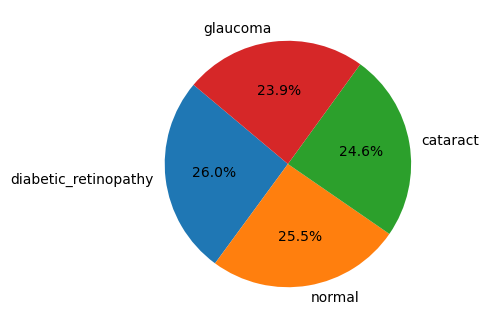

In [8]:
plt.figure(figsize=(12, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.show();

In [9]:
missing_values = df.isnull().sum()
print(missing_values)

Label    0
image    0
dtype: int64


👉 There is no missing value in the image dataset

##  3.2 Display Sample Images from Each Class

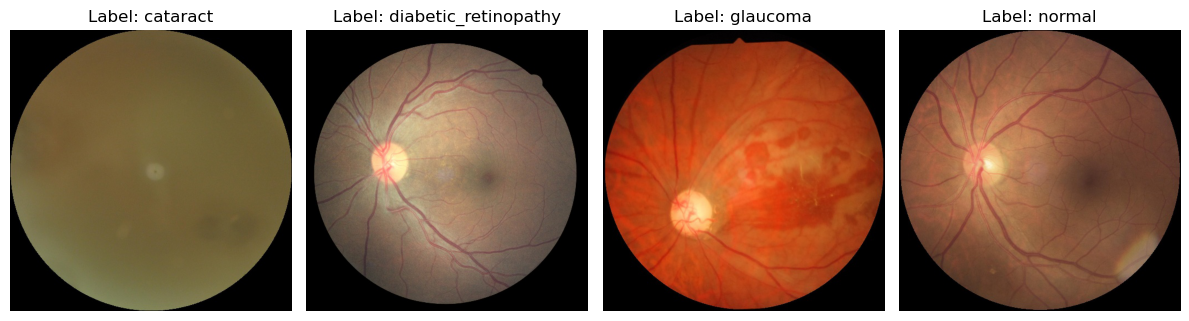

In [10]:
def display_sample_images(df, n=3):
    plt.figure(figsize=(12, 5))
    labels_seen = set()
    images_to_display = []

    for index, row in df.iterrows():
        label = row['Label']
        img_path = row['image']
        if label in labels_seen:
            continue
        images_to_display.append((label, img_path))
        labels_seen.add(label)
        if len(images_to_display) == 4:
            break

    for i, (label, img_path) in enumerate(images_to_display):
        img = mpimg.imread(img_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(df, n=4)

In [11]:
def calculate_image_size(image_path):
    try:
        img = Image.open(image_path)
        width, height = img.size
        return width, height
    except IOError:
        print(f"Failed to open image: {image_path}")
        return None

num_images_to_print = 3
for i in range(min(num_images_to_print, len(class_labels))):
    label, image_path = class_labels[i]
    size = calculate_image_size(image_path)
    if size:
        print(f"Image: {image_path} | Size: {size[0]}x{size[1]} pixels")

Image: C:/Users/91733/OneDrive/Desktop/FinalProjectGuvi/M19M20 & M21M22-20240522T054536Z-001/M19M20 & M21M22/data (3)/dataset\cataract\0_left.jpg | Size: 512x512 pixels
Image: C:/Users/91733/OneDrive/Desktop/FinalProjectGuvi/M19M20 & M21M22-20240522T054536Z-001/M19M20 & M21M22/data (3)/dataset\cataract\103_left.jpg | Size: 512x512 pixels
Image: C:/Users/91733/OneDrive/Desktop/FinalProjectGuvi/M19M20 & M21M22-20240522T054536Z-001/M19M20 & M21M22/data (3)/dataset\cataract\1062_right.jpg | Size: 512x512 pixels


In [12]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
df.head()

,Label,image
0,0,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
1,0,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
2,0,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
3,0,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4,0,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...


In [13]:
df.tail()

,Label,image
4212,3,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4213,3,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4214,3,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4215,3,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...
4216,3,C:/Users/91733/OneDrive/Desktop/FinalProjectGu...


In [14]:
class_counts = df['Label'].value_counts()
print(class_counts)

1    1098
3    1074
0    1038
2    1007
Name: Label, dtype: int64


## 3.3  Train-Test Split

In [15]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (2698, 2)
Validation shape: (675, 2)
Test shape: (844, 2)


In [16]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [17]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image'].values, train_df['Label'].values))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image'].values, val_df['Label'].values))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels)

(32, 256, 256, 3)
tf.Tensor([0 3 3 3 0 1 3 2 3 3 1 0 3 3 1 0 2 0 1 2 0 3 0 2 3 3 2 1 0 1 2 3], shape=(32,), dtype=int32)


#4. Model Building

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\91733\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])


loss, accuracy = model.evaluate(val_ds)
print(f'Validation accuracy: {accuracy}')

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.4733 - loss: 1.2511 - val_accuracy: 0.5022 - val_loss: 0.9645
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6409 - loss: 0.7748 - val_accuracy: 0.7378 - val_loss: 0.6187
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7204 - loss: 0.6519 - val_accuracy: 0.7719 - val_loss: 0.5464
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7597 - loss: 0.5587 - val_accuracy: 0.7926 - val_loss: 0.4875
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7868 - loss: 0.4949 - val_accuracy: 0.8059 - val_loss: 0.4990
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8100 - loss: 0.4589 - val_accuracy: 0.7704 - val_loss: 0.5681
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8193 - loss: 0.4469 - val_accuracy: 0.8119 - val_loss: 0.4996
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.7769 - loss: 0.5063
Validation accuracy: 0.792592585086

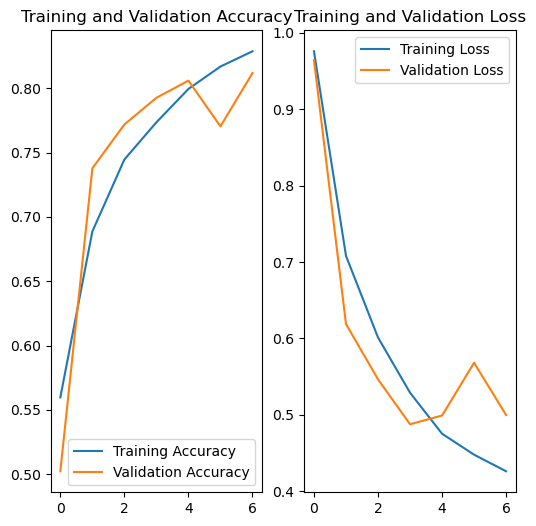

In [23]:
epochs=7
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4.3 Evaluate the Model on Test Data

In [24]:
test_data = tf.data.Dataset.from_tensor_slices((test_df['image'].values, test_df['Label'].values))
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
results = model.evaluate(test_data, verbose=1)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 534ms/step - accuracy: 0.7788 - loss: 0.5592
Test Loss: 0.5458481907844543
Test Accuracy: 0.7772511839866638


## 4.1 DenseNet

In [25]:
input_shape=(256,256,3)
batch_size=64
classes=4
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)

In [26]:
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,432,772 (58.87 MB)

 Trainable params: 8,393,220 (32.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [27]:
patience = 5 
factor = 0.5  
stop_patience = 10  

callbacks = [
    ModelCheckpoint("densenet121.keras", save_best_only=True, verbose=1), 
    ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1)
]

In [28]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 15, verbose = 1, callbacks = callbacks)

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7143 - loss: 1.7876
Epoch 1: val_loss improved from inf to 0.50053, saving model to densenet121.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step - accuracy: 0.7152 - loss: 1.7807 - val_accuracy: 0.8756 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8742 - loss: 0.3500
Epoch 2: val_loss improved from 0.50053 to 0.30086, saving model to densenet121.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 615s 7s/step - accuracy: 0.8742 - loss: 0.3500 - val_accuracy: 0.8904 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8961 - loss: 0.2624
Epoch 3: val_loss improved from 0.30086 to 0.27536, saving model to densenet121.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 608s 7s/step - accuracy: 0.8961 - loss: 0.2625 - val_accuracy: 0.8904 - val_loss: 0.2754 - learning_rate: 0.0010
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9189 - loss: 0

In [29]:
model.save("densenet121.keras")

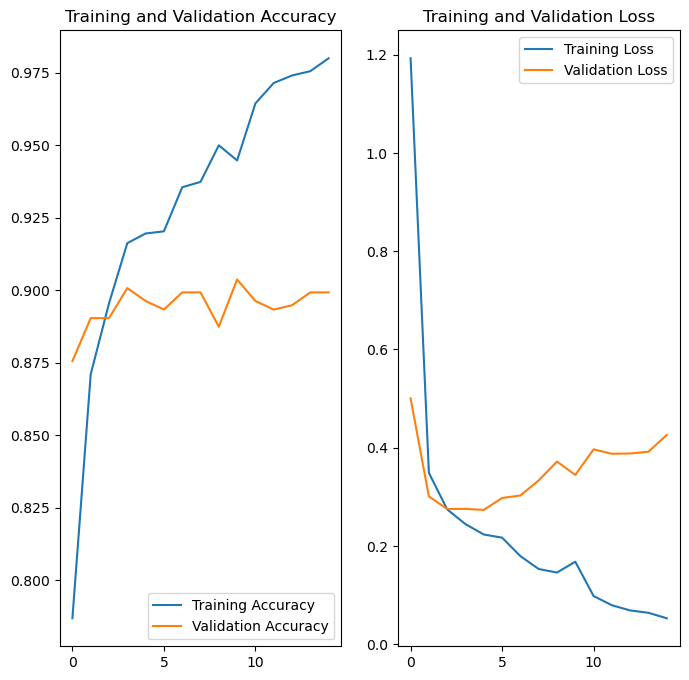

In [31]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
preformance = model.evaluate(val_ds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8997 - loss: 0.4042


In [33]:
results = model.evaluate(test_data, verbose=1)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9059 - loss: 0.3576
Test Loss: 0.3668748140335083
Test Accuracy: 0.9075829386711121


#### Model Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


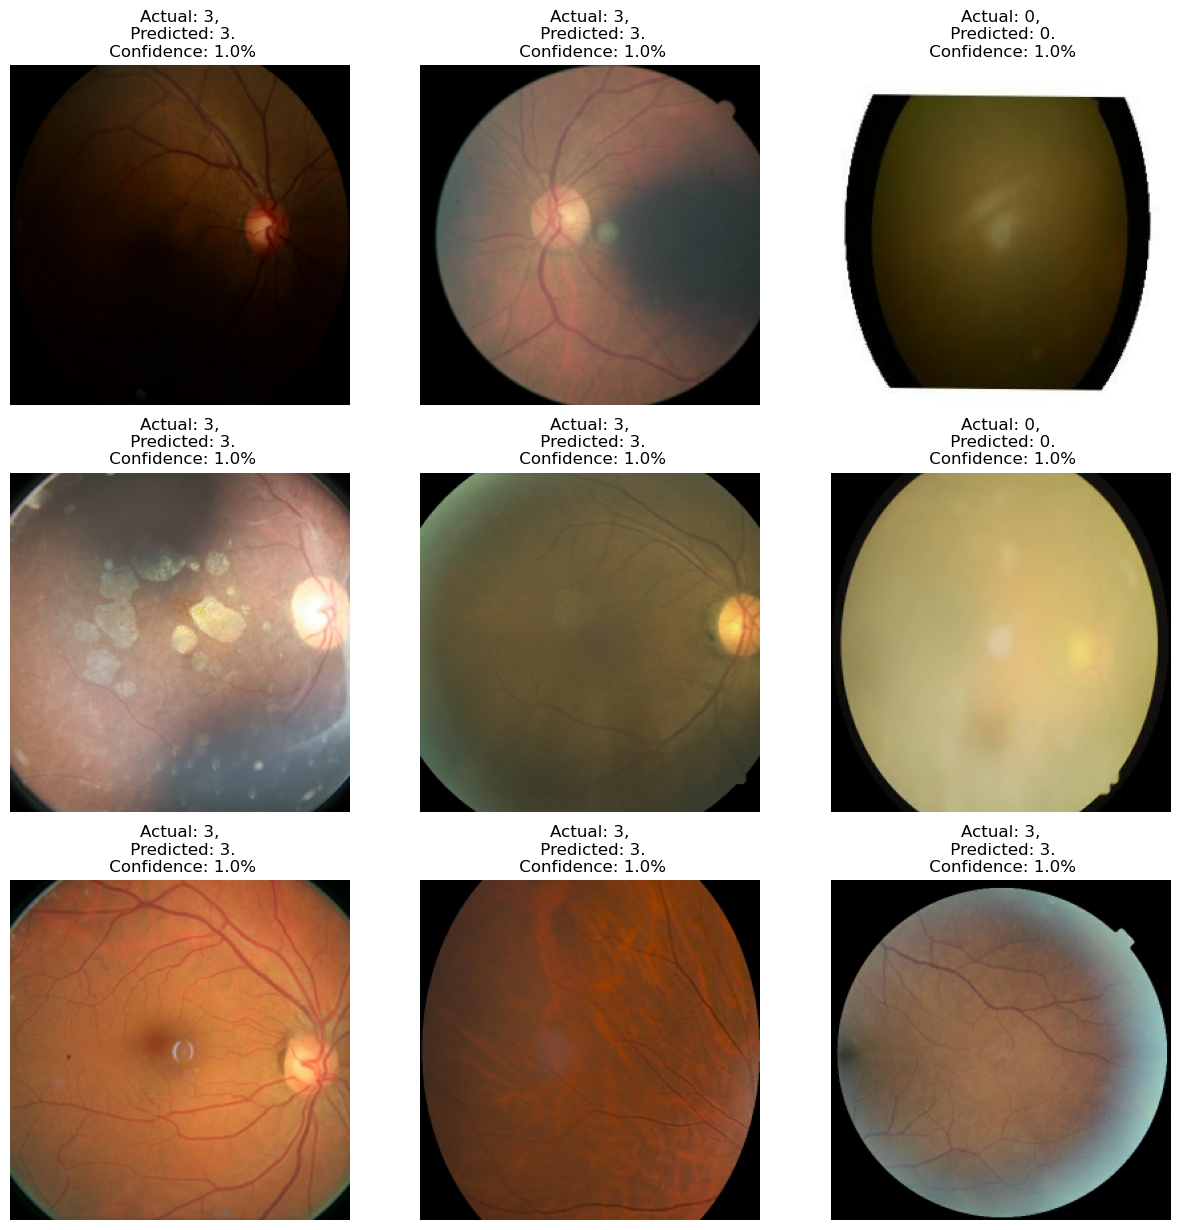

In [34]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (256, 256))  # Resize if necessary
    image = image / 255.0  # Scale images to [0, 1]
    return image, label

def predict(model, img):
    img_array = tf.expand_dims(img, 0)  # Expand dimensions for batch
    predictions = model.predict(img_array)
    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))

for images, lbs in val_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        
        # Rescale to [0, 255] for display
        img = (img * 255).astype("uint8")
        
        plt.imshow(img)
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")